In [1]:
# importing all the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

In [2]:
# DATADIR contains the path of our directory named dataset
# CATEGORIES contains list of subfolders inside the dataset folder
DATADIR = "dataset"
CATEGORIES = ["mask", "nomask"]

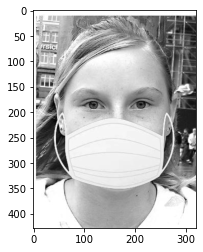

In [3]:
# trying to fetch single image from the dataset folder
# and converting it into an array
# and displaying it in gray scale

for category in CATEGORIES: 
    path = os.path.join(DATADIR,category) 
    for img in os.listdir(path):  # iterate over each image per masks and nomasks
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert image to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!

In [4]:
print(img_array)

[[255 255 255 ... 254 254 254]
 [255 255 255 ... 254 254 254]
 [255 255 255 ... 254 254 254]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 254 ... 255 255 255]
 [255 255 254 ... 255 255 255]]


In [5]:
print(img_array.shape) # 428 tall, 320 wide

(428, 320)


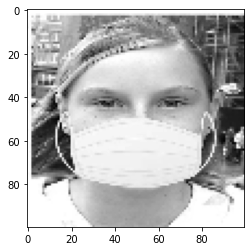

In [6]:
# resizing the image to a fixed dimensions
# i.e 100 x 100

IMG_SIZE = 100

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

In [7]:
training_data = []

# all the above steps are repeated once again, this time
# for all the images in the different folders inside the
# dataset folder i.e converting to array, resizeing, adding to dataset

def create_training_data():
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(DATADIR,category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass

In [8]:
# calling the create_dataset() function

create_training_data()

100%|██████████████████████████████████████████████████████████████████████████████| 649/649 [00:00<00:00, 1158.67it/s]


In [9]:
# printing the no of items inside the training_data (dataset)

print(len(training_data))

1302


In [10]:
# we need to shuffle the contents inside the dataset 
# to prevent any bias during the training and prevent 
# the model from learning the order of the training

import random

random.shuffle(training_data)

In [11]:
# as you can see below the contents are mixed well

for sample in training_data[:10]:
    print(sample[1])

0
1
1
1
1
1
0
1
0
0


In [12]:
# after our dataset(training_data) is created we need 
# to import it into two  empty list X- which contains
# the images or the features and y- which contain the 
# labels later it will be divided into train and test

X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE, 1))

# converting the X and y to numpy array

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)

[[[[197]
   [197]
   [197]
   ...
   [195]
   [195]
   [193]]

  [[195]
   [195]
   [197]
   ...
   [194]
   [196]
   [195]]

  [[193]
   [195]
   [194]
   ...
   [197]
   [198]
   [199]]

  ...

  [[ 23]
   [ 21]
   [ 22]
   ...
   [198]
   [203]
   [188]]

  [[ 20]
   [ 22]
   [ 20]
   ...
   [205]
   [203]
   [208]]

  [[ 17]
   [ 16]
   [ 17]
   ...
   [206]
   [202]
   [205]]]]


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [14]:
# scaling the dataset
# dividing the image pixels with 255 so that
# all pixels lies in range of zeros and ones

X = X/255.0 

In [15]:
# DEFINING THE MODEL

model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(64))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(
              loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [16]:
# displaying the summary of the model

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 256)       2560      
                                                                 
 activation (Activation)     (None, 98, 98, 256)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 256)       590080    
                                                                 
 activation_1 (Activation)   (None, 47, 47, 256)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 256)      0         
 2D)                                                    

In [17]:
# spliting the training_dataset(or simply dataset) into  training
# dataset and testing dataset;testing dataset contains 10% of all
# contents in the training_dataset(dataset)

from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(X,y,test_size=0.1)

In [18]:
history = model.fit(
    X, y, batch_size=32, epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ], validation_split=0.3
)

Epoch 1/5
29/29 [==============================] - 49s 2s/step - loss: 1.2325 - accuracy: 0.5675 - val_loss: 0.5874 - val_accuracy: 0.7033
Epoch 2/5
29/29 [==============================] - 48s 2s/step - loss: 0.4463 - accuracy: 0.8057 - val_loss: 0.3979 - val_accuracy: 0.8235
Epoch 3/5
29/29 [==============================] - 48s 2s/step - loss: 0.2810 - accuracy: 0.8957 - val_loss: 0.2903 - val_accuracy: 0.8696
Epoch 4/5
29/29 [==============================] - 47s 2s/step - loss: 0.1804 - accuracy: 0.9385 - val_loss: 0.1711 - val_accuracy: 0.9386
Epoch 5/5
29/29 [==============================] - 47s 2s/step - loss: 0.1401 - accuracy: 0.9495 - val_loss: 0.1697 - val_accuracy: 0.9386


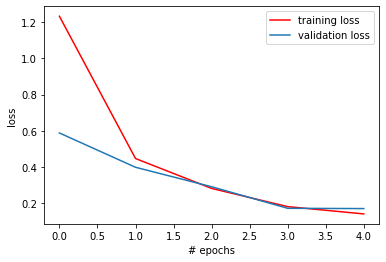

In [19]:
# epochs vs losses for training loss and validation loss
plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


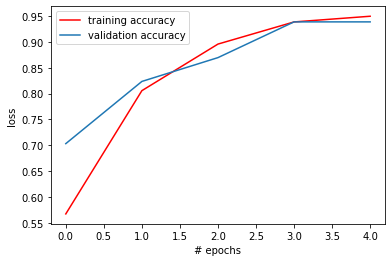

In [20]:
# epochs vs losses for training accu and validation accu
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [21]:
# evaluating the model with the help of testing dataset
# and getting the loss: 11.09 % and an accuracy: 96.18%

print(model.evaluate(test_data,test_target))

5/5 [==============================] - 2s 302ms/step - loss: 0.1170 - accuracy: 0.9618
[0.1169615238904953, 0.9618320465087891]


In [22]:
CATEGORIES = ["MASK", "NO MASK"]

# prepare function: for prepareing the images that we want to predict
# with the help of the model; the function will convert image into an
# array, convert to grayscale and resizeing it.

def prepare(filepath):
    IMG_SIZE = 100                                           # image size of 100 of the prediction img
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)   # read in the image, convert to grayscale
    plt.imshow(img_array, cmap='gray')                       # ploting the image
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize image to match models expected sizing
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)      # return the image with shaping that TF wants.

In [ ]:
# PERFORMING PREDICTION USING AN INTERNET IMAGE

1/1 [==============================] - 0s 38ms/step
0.0
MASK


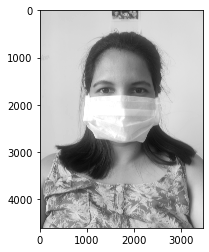

In [26]:
prediction = model.predict([prepare('mask.jpg')])
print(prediction.item())  # will be a list in a list.
print(CATEGORIES[int(prediction[0][0])])

1/1 [==============================] - 0s 36ms/step
1.0
NO MASK


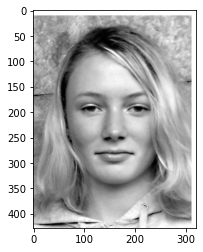

In [25]:
prediction = model.predict([prepare('nomask.jpg')])
print(prediction.item())  # will be a list in a list.
print(CATEGORIES[int(prediction[0][0])])